# 3 - Modelling - IMDb Dataset
In this noteboook, we will create, evaluate and improve two machine learning models to predict whether a review contains a spoiler.
1. Multinomial Naive Bayes
2. Support Vector Classifiers

> Note: As the dataset size is very large, we are using two simple models to evaluate in this notebook.

**Dataset**: [IMDb Spoilers Dataset](https://www.kaggle.com/rmisra/imdb-spoiler-dataset).

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import joblib 

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

# set random seed
np.random.seed(42)

# Load Data

In [2]:
# locate data files
data_dir = pathlib.Path('../data/processed_dataset')
filename = 'processed_sample.csv'

# Read the json files.
data_df = pd.read_csv(data_dir / filename)

In [3]:
data_df.head()

,is_spoiler,review_text,review_summary
0,0,seeing movie duty plea e every serious sci fan...,destined movie
1,0,kept seeing getting compared indiana jones mov...,wish matthew mcconaughey would get struck ligh...
2,0,dark netflix german tv show talk mysterious di...,incredible incredible
3,0,start state clich like movie pretentious film ...,wachowski matrix brother really
4,0,comment may contain spoiler seen came mixed fe...,scary time suffers bad script


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   is_spoiler      25000 non-null  int64 
 1   review_text     25000 non-null  object
 2   review_summary  24922 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


# Data Preparation

In [5]:
num_of_samples = 500_000
data_df2 = data_df.iloc[:num_of_samples]
X = data_df2['review_text']
y = data_df2['is_spoiler']


# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

In [6]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_test_trans = vectorizer.transform(X_test)

In [7]:
# train model
model = MultinomialNB()

# Get cross validated score
scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         cv=10,
                         verbose=3,
                         n_jobs=-1,
                         scoring='roc_auc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


In [8]:
scores.mean()

0.6447924386724386

<BarContainer object of 10 artists>

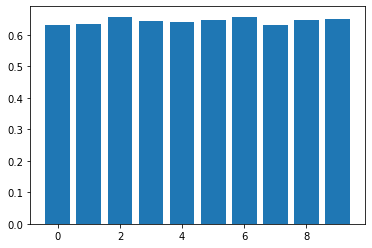

In [9]:
fig, ax = plt.subplots()

ax.bar(x=range(len(scores)), height=scores)

In [10]:
# train the model
model.fit(X_train_trans, y_train)

# predict on the test data
y_pred = model.predict(X_test_trans)

# cehck 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2779
           1       0.51      0.36      0.42       971

    accuracy                           0.75      3750
   macro avg       0.65      0.62      0.63      3750
weighted avg       0.72      0.75      0.73      3750



# Does more data improve the performance of the model?

In [11]:
#Define Plot for learning curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=X_train_trans, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall',random_state=42)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
#     plt.ylim([0.6, 1.0])
    plt.show()

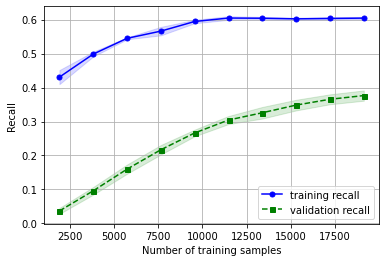

In [12]:
plot_learning_curves(model)

# Model Comparison

In [13]:
from sklearn.svm import SVC

# Instanciate model
clf_svc = SVC(kernel='linear', probability=True)
clf_NB = MultinomialNB()

In [14]:
from helper_functions import evaluate_model


# Setting seed to ensure reproducability
np.random.seed(100)

# Transform data
X_trans = vectorizer.transform(X)

In [15]:
# Getting Metric scores on each model
print('Evaluating Multinomial Naive Bayes Model')
eval_NB = evaluate_model(clf_NB, X_trans, y, False)

print('Evaluating Support Vector Machine')
eval_svc = evaluate_model(clf_svc, X_trans[:1_000], y[:1_000], False)

df = pd.DataFrame({'Linear SVC': eval_svc,
                   'Multinomial Naive Bayes': eval_NB})

Evaluating Multinomial Naive Bayes Model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Model evaluation complete.
Evaluating Support Vector Machine


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Model evaluation complete.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


## Plotting the results

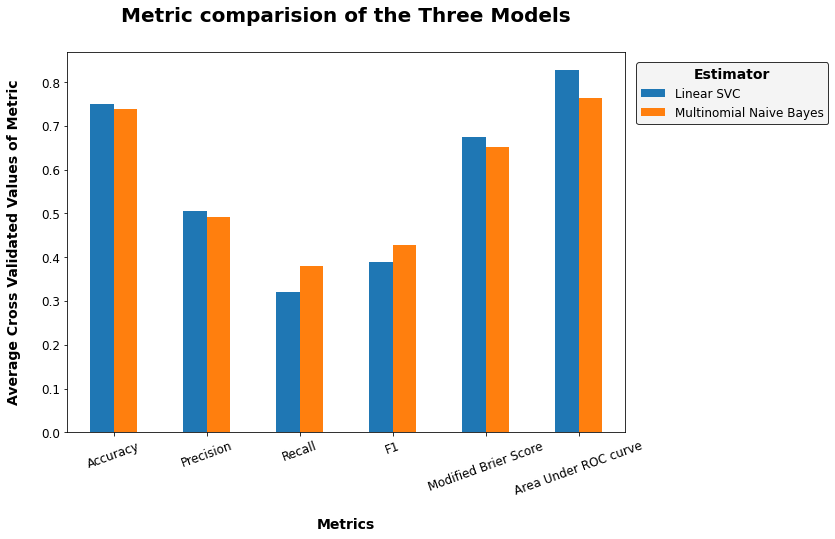

In [16]:
# Instantiating figure
fig, ax = plt.subplots(figsize=(10,7))

# plotting data
df.plot.bar(ax=ax)

# Formatting title and axes
ax.set_title("Metric comparision of the Three Models", 
             fontdict={"fontsize":20, "fontweight":'bold'},
             pad=30)

ax.set_xlabel("Metrics", fontsize=14, fontweight='bold', labelpad=20)
ax.set_ylabel("Average Cross Validated Values of Metric", 
              fontsize=14, fontweight='bold', labelpad=20)

locs, labels = plt.xticks()
plt.xticks(locs, ['Accuracy', 'Precision', 'Recall', 'F1', 'Modified Brier Score', 'Area Under ROC curve'], 
           fontsize=12, rotation=20)
plt.yticks(fontsize=12)
# ax.set_ylim([0.8, 1])

# Formatting legend
leg = ax.legend(fontsize=12, loc=(1.02, 0.81), frameon=True)
leg.get_frame().set_color("#F2F2F2")
leg.get_frame().set_edgecolor("#000000")
leg.set_title("Estimator", prop={"size": 14, "weight": 'bold'})

Though the performance of the `Linear SVC model` is lower than the `Multinomial Naive Bayes` in some aspects, however, the Linear SVC model has only been trained on 

### Experiment for Hyperparameter Tuning for Multinomial NB

In [18]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# define models
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
elastic = linear_model.ElasticNet()
lasso_lars = linear_model.LassoLars()
bayesian_ridge = linear_model.BayesianRidge()
logistic = linear_model.LogisticRegression(solver='liblinear')
sgd = linear_model.SGDClassifier()

models = [ridge, lasso, elastic, logistic, sgd]

# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model, X_train_trans, y_train, cv=5, scoring='roc_auc')
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')
    
# loop through list of models
for model in models:
    print(model)
    get_cv_scores(model)

Ridge()
CV Mean:  0.6192680435157948
STD:  0.00957625013249276


Lasso()
CV Mean:  0.5
STD:  0.0


ElasticNet()
CV Mean:  0.5
STD:  0.0


LogisticRegression(solver='liblinear')
CV Mean:  0.6555320634920634
STD:  0.008482394936555735


SGDClassifier()
CV Mean:  0.656952352092352
STD:  0.010801356950529254




In [19]:
#Original Model - NB
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('NB', MultinomialNB())]: 
    method.fit(X_train_trans,y_train)
    y_pred = method.predict(X_test_trans)
    print('\nEstimator: {}'.format(name)) 
    print('\n', confusion_matrix(y_test, y_pred))  
    print(classification_report(y_test, y_pred))


Estimator: NB

 [[2450  329]
 [ 625  346]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2779
           1       0.51      0.36      0.42       971

    accuracy                           0.75      3750
   macro avg       0.65      0.62      0.63      3750
weighted avg       0.72      0.75      0.73      3750



In [29]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# train model
model = MultinomialNB()

pipe_mnb = Pipeline([('clf', MultinomialNB())])

In [30]:
from sklearn.naive_bayes import MultinomialNB
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
#alpha=[1.0]
fit_prior=[True]
class_prior=[None]

In [31]:
#Set grid search params 
param_gridmnb = dict(alpha=alpha,
                  fit_prior=fit_prior,
                  class_prior=class_prior)

In [32]:
#Optimize Models 

grid = GridSearchCV(estimator=model, param_grid=param_gridmnb,
                       cv=10, verbose=0,scoring='roc_auc',n_jobs=-1)

In [33]:
# List of pipelines for ease of iteration 
grids = [grid] 

In [34]:
# Dictionary of pipelines and classifier types for ease of reference 
grid_dict = {0:'mnb'}

grid_result = grid.fit(X_train_trans, y_train)

In [35]:
# train the model
model.fit(X_train_trans, y_train)

# predict on the test data
y_pred = model.predict(X_test_trans)

# cehck 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2779
           1       0.51      0.36      0.42       971

    accuracy                           0.75      3750
   macro avg       0.65      0.62      0.63      3750
weighted avg       0.72      0.75      0.73      3750



In [36]:
#Create Confusion Matrix Table and Report

for idx, gs in enumerate(grids):
    
    #Fit grid search
    gs.fit(X_train_trans, y_train)
    # Predict on test data with best params 
    y_pred = gs.predict(X_test_trans) 
    
    #Create Dataframe to Compare Models
    print('\nEstimator: {}'.format(grid_dict[idx])) 
    print('\n', confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred))  


Estimator: mnb

 [[2450  329]
 [ 625  346]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2779
           1       0.51      0.36      0.42       971

    accuracy                           0.75      3750
   macro avg       0.65      0.62      0.63      3750
weighted avg       0.72      0.75      0.73      3750



In [37]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.6447924386724386
Best Params:  {'alpha': 1, 'class_prior': None, 'fit_prior': True}


### Experiment for Hyperparameter Tuning for SVC

In [38]:
# train model
model = SVC()

In [39]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = {'C': [1, 10, 100, 1000], 'kernel': ['rbf', 'linear'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train_trans[:1000], y_train[:1000])

In [40]:
accuracy = grid_search.best_score_

In [41]:
accuracy

0.6664220332028551

In [42]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
classifier = SVC(kernel = 'rbf', gamma=0.1)
classifier.fit(X_train_trans[:1000], y_train[:1000])

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test[:1000])

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)

In [ ]:
accuracy

# Save the Best Model

In [ ]:
# save model 
joblib.dump(df['Multinomial Naive Bayes'], '../models/spoiler-detection-model.pkl')

In [ ]:
# save count vectorizer
joblib.dump(vectorizer, '../preprocessing/count-vectorizer.pkl')

# Model Deployment with Algorithmia
The algorithm is deployed using the [Algorithmia platform](https://algorithmia.com/). The following code runs a test code.

In [ ]:
import Algorithmia
import json


with open('auth.json') as f:
    CLIENT_ID = json.load(f)['CLIENT_ID']

In [ ]:
try:
    test = "This text should contain spoiler. Batman  at the end of the movie."
    client = Algorithmia.client(CLIENT_ID)
    algo = client.algo('radroid/spoiler_detection/0.1.0')
    algo.set_options(timeout=300) # optional
    print(algo.pipe(test).result)
except:
    print("Error occurred.")

## Code for JavaScript
The following piece of code can be used in Javascript to get a prediction for the text.

**Add the Algorithmia JavaScript client in your HTML:**
```
<script src="https://algorithmia.com/v1/clients/js/algorithmia-0.2.1.js" type="text/javascript"></script>
```

**Use**
```
var input = "This text should contain a spoiler. Batman dies at the end of the movie.";
Algorithmia.client("CLIENT_ID")
  .algo("radroid/spoiler_detection/0.1.0?timeout=300") // timeout is optional
  .pipe(input)
  .then(function(output) { console.log(output); });
```

# Section to be completed - AP

## Overview

> _The model detects spoilers in the textual data provided. It accepts a list/array of strings and returns a list/array of boolean values. The model uses Multinomial Naive Bayes algorithm for text classification._

### Applicable Scenarios and Problems


> _The model can be used by applications which intend to detect spoiler review comments for movies. It is suitable for classifying if the textual content (array/list of strings) passed is a spoiler or not. For training the model we have used movies dataset from IMDb._

## Usage

### Input

> _The model accepts a list/array of strings as input._

| Parameter | Description |
| --------- | ----------- |
| test     | Array/List of Strings |


 * Since the text content passed are user review comments, they may have emojis and slang words. 
 * Content from web pages, may have HTML tags.
 
It's better to remove such content before passing to the model to reduce the pre-processing load. 

### Output

_The output is displayed as a list/array of booleans of same size as the input list/array. Each element of the output array indicates if the corresponding element in the input array is a spoiler or not.
[1] indicates spoiler
[0] indicates not a spoiler_

| Parameter | Description |
| --------- | ----------- |
| result     | Array/List of Boolean values |

## Examples

_Running the model from command prompt._
1. Output 1 is displayed for a spoiler text.
> 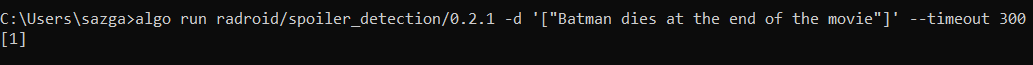

2. Ouptut 0 is displayed for a non-spoiler text.
> 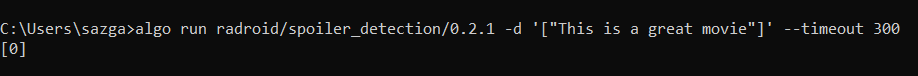




# Extras Code Snippets

In [ ]:
test = 'Here’s a conundrum: how do you wrap up a 22-movie saga, follow up the most iconic shock blockbuster ending since The Empire Strikes Back, and provide a satisfying ending for some of the most beloved screen heroes of the last decade? If you’re Avengers: Endgame, you do it with stunning ease – the Marvel Cinematic Universe’s latest offering a powerful, emotion, thrilling and playful three-hour epic, stuffed with fan service and jaw-dropping pay-offs. Empire sat down with the films directors, Anthony and Joe Russo, and its writers, Christopher Markus and Stephen McFeely, for some spoiler-heavy conversations, talking the film’s major revelations, twists, deaths, and more – and they delivered all kinds of fascinating insights into one of the biggest movies of all time.'
test

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from string import punctuation 

stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [ ]:
%%timeit
clean_message = text_cleaning("This text should contain spoiler. Batman dies at the end of the movie.")

test1 = vectorizer.transform([clean_message])

prediction = model.predict_proba(test1)
prediction

In [ ]:
# Preprocess and Create numpy array from the input
message = "Snape kills Dumbledore in Harry Potter."
clean_message = text_cleaning(message)

#vectorize the message 
vect_message = vectorizer.transform([clean_message])

prediction = model.predict_proba(vect_message)
round(prediction[0][1]*100, 1)